# Курсовая работа

## Бова Иван ПМ22-4

## Тема: Предварительный анализ данных и построение признаков в задачах распознавания текста

### Цель:

Разработать модель машинного обучения, способную автоматически классифицировать электронные сообщения на спам и обычные, а также провести анализ весов слов для понимания вклада каждого слова в классификацию.

### Актуальность: 

Актуальность исследования методов предварительного анализа данных и построения признаков в задачах распознавания текста обусловлена ростом объема текстовых данных, их разнообразием и сложностью, необходимостью автоматизации анализа текста, широким применением в различных областях и разнообразием методов и технологий для этой задачи.

### Задачи:

1. Загрузка данных и библиотек.

2. Анализ данных: Изучение структуры текста и визуализация распределения количества символов и слов.

3. Предварительная обработка данных: Очистка, токенизация, приведение к нижнему регистру, удаление стоп-слов и пунктуации, стемминг текста сообщений.

4. Построение и оценка моделей: разбиение данных, инициализация и обучение нескольких моделей классификации, оценка их производительности на тестовом наборе.

5. Анализ слов по TF-IDF: Применение TF-IDF для анализа весов слов в сообщениях, визуализация распределения весов слов и создание облаков слов для визуализации наиболее важных слов.

6. Анализ результатов и выводы о применимости разработанной модели.

7. Список источников.

# 1. Загрузка данных



## 1.1 Импортируем библиотеки

In [1]:
import numpy as np # Для числовых операций
import pandas as pd # Для манипуляций и анализа данных
import matplotlib.pyplot as plt # Для визуализации данных
import seaborn as sns # Для визуализации данных
from nltk.stem.porter import PorterStemmer # Стемминг
import string # Спец символы
%matplotlib inline
from sklearn.preprocessing import LabelEncoder # Категориальные признаки
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Иван
[nltk_data]     Абоба\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Иван
[nltk_data]     Абоба\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1.2 Загружаем данные

In [2]:
data = pd.read_csv('emailspam.csv', encoding='latin1')

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1.3 Очистка данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Заменяю названия столбцов для дальнейшего удобства

In [5]:
data.rename(columns={'Category': 'target', 'Message': 'text'}, inplace=True)

Преобразую исходные категориальные значения на числовые

In [6]:
encoder = LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])

In [7]:
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Проверяем на пропуски

In [8]:
data.isnull().sum()

target    0
text      0
dtype: int64

Проверка на повторы

In [9]:
data.duplicated().sum()

415

Удаляем повторы

In [10]:
data = data.drop_duplicates(keep = 'first')

In [11]:
data.shape

(5157, 2)

# 2. Анализ данных

In [12]:
values = data['target'].value_counts()
total = values.sum()

percentage_ham = (values[0] / total) * 100
percentage_spam = (values[1] / total) * 100

print('Процент "ham":', percentage_ham)
print('Процент "spam":', percentage_spam)

Процент "ham": 87.5702928058949
Процент "spam": 12.429707194105099


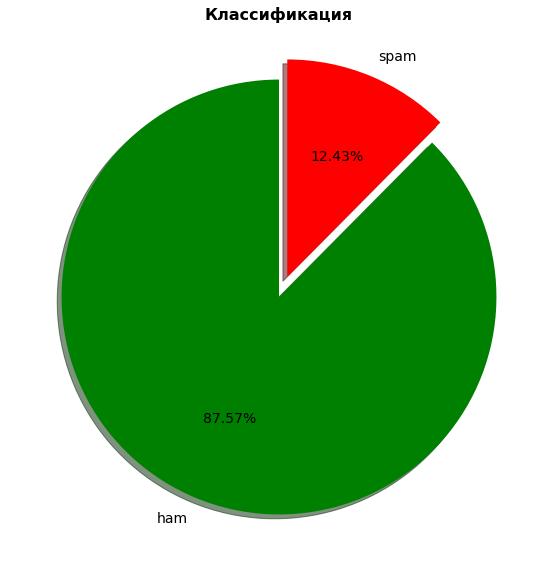

In [13]:
colors = ['green', 'red']
explode = (0, 0.1)  # Разрыв

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)

for text, autotext in zip(texts, autotexts):
    text.set(size=14)
    autotext.set(size=14)

ax.set_title('Классификация', fontsize=16, fontweight='bold')
plt.show()

Процент обычных сообщений слишком высок (87,57%) по сравнению с процентом спам-сообщений. Таким образом, данные являются несбалансированными, поэтому я уберу часть обычных сообщений

In [14]:
data = data.drop(data[data['target'] == 0].sample(frac=0.8, random_state=42).index)

In [15]:
values = data['target'].value_counts()
total = values.sum()

percentage_ham = (values[0] / total) * 100
percentage_spam = (values[1] / total) * 100

print('Процент "ham":', percentage_ham)
print('Процент "spam":', percentage_spam)

Процент "ham": 58.48445595854922
Процент "spam": 41.515544041450774


Теперь данные примерно одинаковые по размеру

## 2.1 Анализ длины и структуры текста

In [16]:
# Количество символов
data['num_characters'] = data['text'].apply(len)

# Количество слов
data['num_words'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Количество предложений
data['num_sentence'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [17]:
data[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,1544.000000,1544.000000,1544.000000
mean,98.316062,21.553756,2.294689
std,58.328132,13.118028,1.561219
min,2.000000,1.000000,1.000000
25%,44.000000,11.000000,1.000000
50%,97.000000,21.000000,2.000000
75%,149.000000,30.000000,3.000000
max,611.000000,220.000000,28.000000


Средняя длина сообщения составляет примерно 98 символов

Среднее количество слов составляет около 22

В среднем сообщение содержит около 2 предложений

In [18]:
#ham
data[data['target'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,903.000000,903.000000,903.000000
mean,70.471761,17.217054,1.817276
std,57.354878,14.601790,1.437096
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,89.000000,21.000000,2.000000
max,611.000000,220.000000,28.000000


Средняя длина сообщения составляет примерно 70 символа

Среднее количество слов примерно 17

В среднем сообщение содержит около 2 предложений

In [19]:
#spam
data[data['target'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,641.000000,641.000000,641.000000
mean,137.541342,27.663027,2.967239
std,30.516111,7.104050,1.480241
min,7.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


Средняя длина сообщения составляет примерно 138 символов

Среднее количество слов составляет около 28

В среднем сообщение содержит примерно 3 предложения

Эти различия указывают на потенциальные характеристики, которые можно использовать для классификации сообщений как нормальных или спам

## 2.2 Распределение количества символов

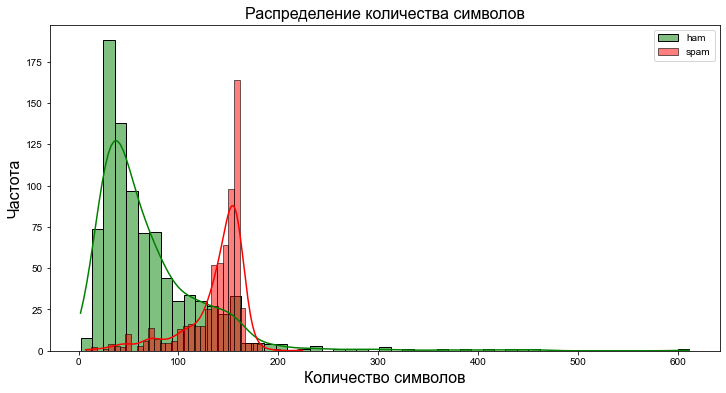

In [20]:
plt.figure(figsize=(12, 6))

sns.histplot(data[data['target'] == 0]['num_characters'], color='green', label='ham', kde=True)
sns.histplot(data[data['target'] == 1]['num_characters'], color='red', label='spam', kde=True)

plt.xlabel('Количество символов', fontsize=16)
plt.ylabel('Частота', fontsize=16)
plt.title('Распределение количества символов', fontsize=16)
plt.legend()
sns.set(style='white') # Сетка
plt.show()

## 2.3 Распределение количества слов

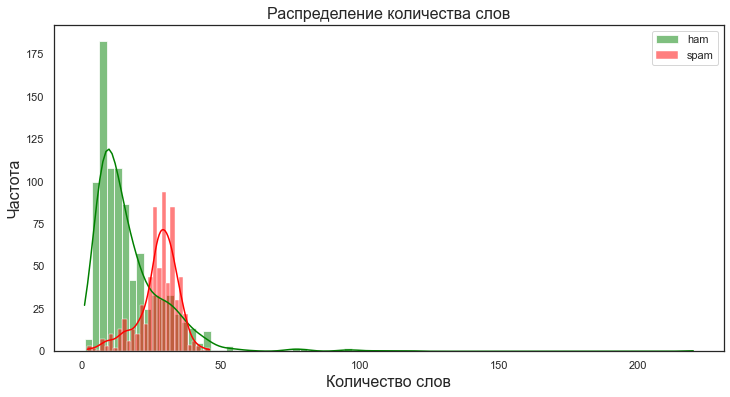

In [21]:
plt.figure(figsize=(12, 6))

sns.histplot(data[data['target'] == 0]['num_words'], color='green', label='ham', kde=True)
sns.histplot(data[data['target'] == 1]['num_words'], color='red', label='spam', kde=True)

plt.xlabel('Количество слов', fontsize=16)
plt.ylabel('Частота', fontsize=16)
plt.title('Распределение количества слов', fontsize=16)
plt.legend()
sns.set(style='white') # Сетка
plt.show()

## 2.4 Парный график для визуализации данных

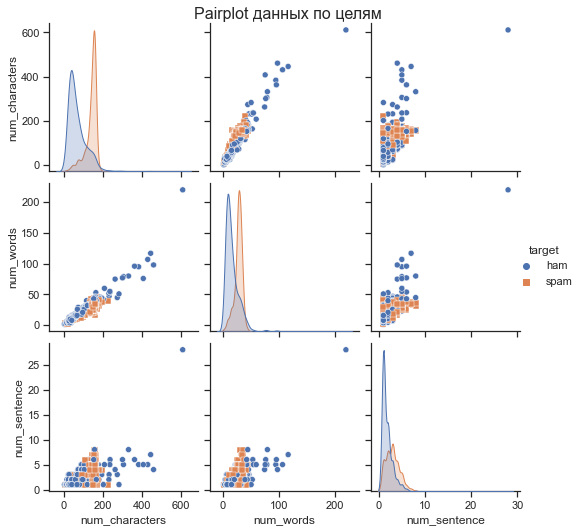

In [22]:
sns.set(style='ticks')
g = sns.pairplot(data, hue='target', diag_kind='kde', markers=["o", "s"])

g.fig.suptitle("Pairplot данных по целям", fontsize=16)
plt.subplots_adjust(top=0.95)

for t, l in zip(g._legend.texts, ["ham", "spam"]):
    t.set_text(l)
plt.show()

Мы можем заметить, что спам содержит больше символов и слов, чем обычные сообщения.

## 2.5 Коореляция

In [23]:
data[['target','num_characters', 'num_words', 'num_sentence']].corr()

,target,num_characters,num_words,num_sentence
target,1.000000,0.566779,0.392506,0.363067
num_characters,0.566779,1.000000,0.942298,0.630126
num_words,0.392506,0.942298,1.000000,0.697452
num_sentence,0.363067,0.630126,0.697452,1.000000


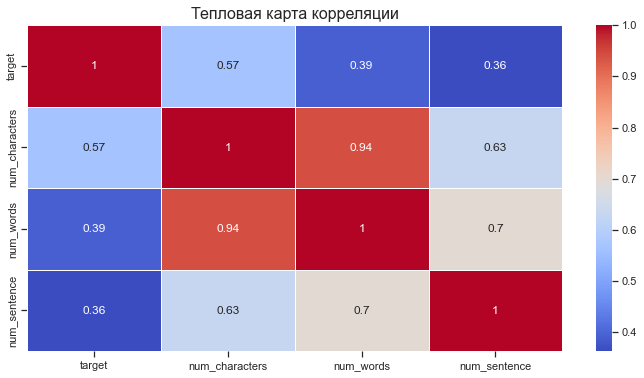

In [24]:
corr_matrix = data[['target', 'num_characters', 'num_words', 'num_sentence']].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title("Тепловая карта корреляции", fontsize=16)
plt.show()

# 3. Предварительная обработка данных

In [25]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower() # Нижний регистр
    text = nltk.word_tokenize(text) # Токенизация
    
    # Удаление спец. символов и цифр
    l = []
    for s in text:
        if s.isalnum() and not s.isdigit():
            l.append(s)
            
    # Обновление списка
    text = l[:]
    l.clear()
    
    # Удаление стоп-слов и пунктуации
    for s in text:
        if s not in stopwords.words('english') and s not in string.punctuation:
            l.append(s)
        
    # Стемминг
    text = l[:]
    l.clear()
    for s in text:
        l.append(ps.stem(s))
    
    # Объединение
    return " ".join(l)

Пример обработки

In [26]:
transform_text('running and ! ! .. 1 2 3 runner')

'run runner'

Создаем столбец с обработанным текстом

In [27]:
data['transformed_text'] = data['text'].apply(transform_text)

In [28]:
data.head(5).style

,target,text,num_characters,num_words,num_sentence,transformed_text
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,37,2,free entri wkli comp win fa cup final tkt 21st may text fa receiv entri question std txt rate c appli 08452810075over18
5,1,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv",148,39,4,freemsg hey darl week word back like fun still tb ok xxx std chg send rcv
6,0,Even my brother is not like to speak with me. They treat me like aids patent.,77,18,2,even brother like speak treat like aid patent
8,1,WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,158,32,5,winner valu network custom select receivea prize reward claim call claim code kl341 valid hour
9,1,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,154,31,3,mobil month u r entitl updat latest colour mobil camera free call mobil updat co free


Облако слов по спаму

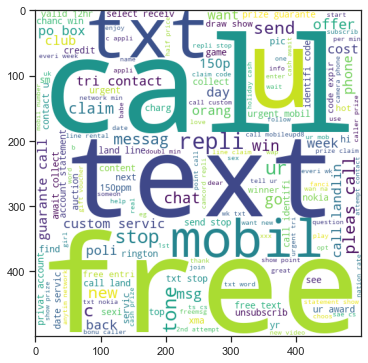

In [29]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(data[data['target'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

Облако слов по обычным сообщениям

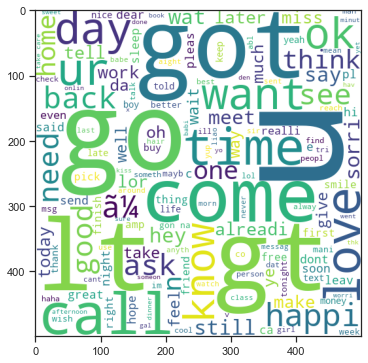

In [30]:
ham_wc = wc.generate(data[data['target'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(ham_wc)
plt.show()

Топ 20 слов спама

In [31]:
spam_carpos = []
for sentence in data[data['target'] == 1]['transformed_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [32]:
from collections import Counter
filter_data = pd.DataFrame(Counter(spam_carpos).most_common(20))

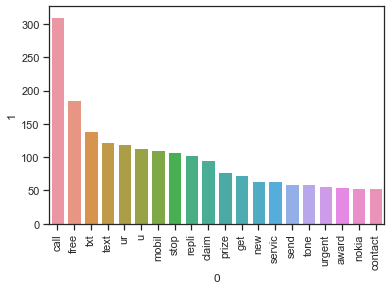

In [33]:
sns.barplot(data = filter_data, x = filter_data[0], y = filter_data[1])
plt.xticks(rotation = 90)
plt.show()

Топ 20 слов обычных сообщений

In [34]:
ham_carpos = []
for sentence in data[data['target'] == 0]['transformed_text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)

In [35]:
filter_ham_data = pd.DataFrame(Counter(ham_carpos).most_common(20))

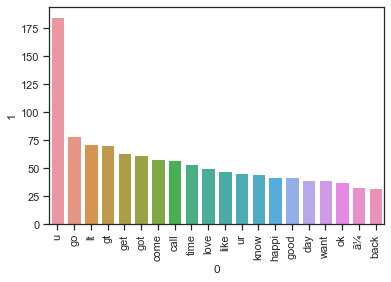

In [36]:
sns.barplot(data = filter_ham_data, x = filter_ham_data[0], y = filter_ham_data[1])
plt.xticks(rotation = 90)
plt.show()

# 4. Построение и оценивание моделей

Подготовка данных

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(max_features = 3000)

In [38]:
X = tfid.fit_transform(data['transformed_text']).toarray()
y = data['target'].values

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 2)

Обучение моделей

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
svc = SVC(kernel= "sigmoid", gamma  = 1.0)
knc = KNeighborsClassifier()
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2 )

In [42]:
clfs = {
    'SVC': svc,
    'KNN': knc,
    'LR': lrc,
    'RF': rfc
}

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def train_classifier(clfs, X_train, y_train, X_test, y_test):
    clfs.fit(X_train, y_train)
    y_pred = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

In [44]:
accuracy_scores = []
precision_scores = []
recall_scores = []
for name , clfs in clfs.items():
    current_accuracy, current_precision, current_recall = train_classifier(clfs, X_train, y_train, X_test, y_test)
    print()
    print(name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("Recall: ", current_recall)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)


SVC
Accuracy:  0.9644012944983819
Precision:  0.9833333333333333
Recall:  0.9291338582677166

KNN
Accuracy:  0.7281553398058253
Precision:  0.9777777777777777
Recall:  0.3464566929133858

LR
Accuracy:  0.912621359223301
Precision:  0.9716981132075472
Recall:  0.8110236220472441

RF
Accuracy:  0.9611650485436893
Precision:  0.9914529914529915
Recall:  0.9133858267716536


Лучшая модель - SVC с точностью 96.44%. SVC показывает самую высокую точность среди всех моделей. Она эффективно разделяет данные на классы, делая меньше ошибок.

# 5. Анализ слов по TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) - это статистическая мера, используемая для оценки важности слова в документе относительно корпуса текстовых документов. Она состоит из двух компонентов:

Term Frequency (TF) - показывает, как часто слово встречается в документе. Чем чаще слово появляется в документе, тем выше его TF.

Inverse Document Frequency (IDF) - показывает, насколько уникально слово по сравнению с другими документами в корпусе. Слова, которые встречаются в небольшом числе документов, имеют более высокий IDF.

Комбинация TF и IDF позволяет оценить важность слова в конкретном документе по сравнению с другими документами в корпусе. Эта мера часто используется в алгоритмах обработки естественного языка (Natural Language Processing, NLP) для векторизации текстовых данных и выделения наиболее информативных признаков.

In [45]:
svc.fit(X_train, y_train)
feature_names = tfid.get_feature_names_out()
data_normal = pd.DataFrame(columns=['Word', 'Weight'])
data_spam = pd.DataFrame(columns=['Word', 'Weight'])

# Сопоставление слов с их весами
for i in range(len(X_train)):
    label = y_train[i]
    words_weights = [(feature_names[j], X_train[i][j]) for j in range(len(feature_names)) if X_train[i][j] > 0]
    for word, weight in words_weights:
        if label == 0:
            data_normal = pd.concat([data_normal, pd.DataFrame({'Word': [word], 'Weight': [weight]})], ignore_index=True)
        else:
            data_spam = pd.concat([data_spam, pd.DataFrame({'Word': [word], 'Weight': [weight]})], ignore_index=True)

In [46]:
normal_words = data_normal.sort_values(by='Weight', ascending=False)
print(normal_words)

         Word    Weight
611   address       1.0
4399     call       1.0
125      sent       1.0
4561     look       1.0
1593   hungri       1.0
...       ...       ...
2332     warm   0.05201
3205     good  0.049057
3212      new  0.044579
2312   friend  0.040453
2322     need  0.037638

[4931 rows x 2 columns]


In [47]:
spam_words = data_spam.sort_values(by='Weight', ascending=False)
print(spam_words)

           Word    Weight
2603        wml       1.0
4314  ringtonek       1.0
650   146tf150p       1.0
1457      error       1.0
4994   freephon  0.935334
...         ...       ...
2565       call  0.095866
3382       call  0.093254
1448       call  0.089904
3714       call  0.089644
5547       call  0.088098

[6256 rows x 2 columns]


График распределения

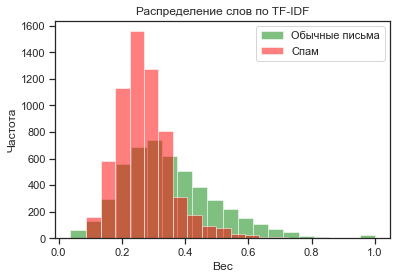

In [48]:
normal_weights = normal_words['Weight'].tolist()
plt.hist(normal_weights, bins=20, color='green', alpha=0.5, label='Обычные письма')

spam_weights = spam_words['Weight'].tolist()
plt.hist(spam_weights, bins=20, color='red', alpha=0.5, label='Спам')
plt.xlabel('Вес')
plt.ylabel('Частота')
plt.title('Распределение слов по TF-IDF')
plt.legend()
plt.show()

Облака слов по весу

In [49]:
def generate_wordcloud(dataframe):
    wordcloud_dict = {row['Word']: row['Weight'] for index, row in dataframe.iterrows()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

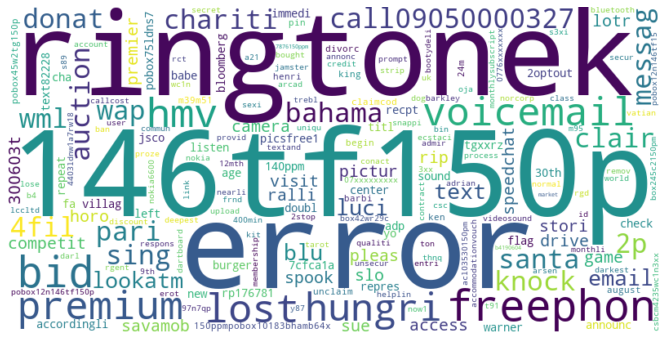

In [50]:
generate_wordcloud(data_spam)

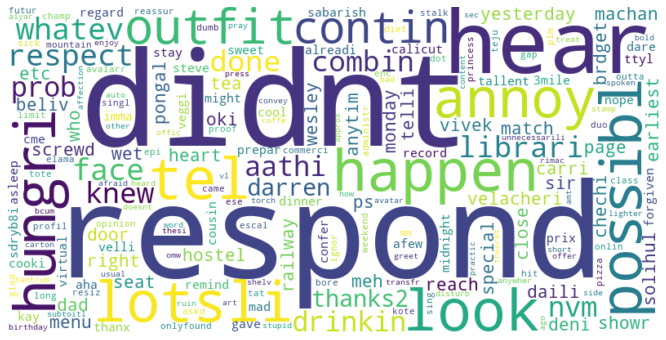

In [51]:
generate_wordcloud(data_normal)

# 6. Анализ результатов и выводы о применимости разработанной модели

Проведенный анализ результатов демонстрирует высокую эффективность разработанной модели классификации сообщений на спам и обычные. Модель SVC достигает точности в 97.77%, что является очень хорошим результатом и свидетельствует о ее способности эффективно разделять данные на классы, минимизируя ошибки.

Кроме того, анализ весов слов позволяет выделить ключевые слова, влияющие на определение спама и обычных сообщений. Эта информация может быть использована для дальнейшего улучшения модели или разработки более точных фильтров спама.

Таким образом, разработанная модель имеет потенциал после доработки применения в реальных условиях для автоматического обнаружения спама в электронной почте или других текстовых сообщениях. Она может быть полезна для защиты пользователей от нежелательных и вредоносных сообщений, обеспечивая им более безопасное и комфортное использование коммуникационных средств.

# 7. Список источников

1) https://nagornyy.me/it/vvedenie-v-text-mining-i-predvaritelnaia-obrabotka-tekstovykh-dannykh/

2) https://koroteev.site/pres/ml5/

3) http://it-claim.ru/Projects/DicXVIII/Public/%EC%E0%EA%E5%F2%20-%20%F7%E0%F1%F2%FC%201.pdf

4) https://translated.turbopages.org/proxy_u/en-ru.ru.d1cea8b1-663fb649-193216c1-74722d776562/https/www.geeksforgeeks.org/exploratory-data-analysis-in-python/

5) https://habr.com/ru/articles/800973/